
# ssmodels:  Local Level Benchmark

Benchmark ssmodel's arma against base-R StructTS. Additional features include:
* N-step point point predictions
* confidence/prediction intervals
* p-values and standard error about coefficient estimates

In [197]:
#install.packages('~/repos/ssmodels/pkg/ssmodels_0.1-0.tar.gz',repos = NULL, type = "source")

### R libraries

In [198]:
library(ssmodels)
library(ggplot2)
library(MASS)
library(repr)

### Nile River test data

In [199]:
y = data(Nile)
y = Nile
y = as.matrix(log10(y))

fit <- StructTS(y,"level")

In [200]:
nSteps = 25
type = "level"

yproc = as.data.frame(y)

### Estimate model using ssmodels

In [201]:
est = estSSModel(yproc, data.frame(), data.frame(), params, type)
coefsMLE = est$coef
mod = est$Z

### Generate fit statistics
* implemented a patch fix for hessian; arimax needs to be debugged
* see note in likSS.R

In [202]:
# -----------------------------------------
# - stats

H = hessian(yproc, coefsMLE, X, D, params, 0.00001, type)
vcov_mle = 2*ginv(H)
se_ssmodel = sqrt(diag(abs(vcov_mle)))
pval_ssmodel = (1-pnorm(abs(coefsMLE)/se_ssmodel))*2

# - check hessian
# coefs = initCoef(yproc,X,params)
# LL = likSS(coefs,params,y,X,D,type)
# optimize = optim(par=coefs, fn=likSS,y=yproc,ord=params,type='arima',X0=X,D0=D,hessian=T)
# coefs_mle = optimize$par
# se2 = sqrt(diag(2*solve(optimize$hessian)))

### Generate fit and predictions using ssmodels

In [203]:
# -----------------------------------------
# - fit

kf = kalmanRun(y,mod)
kf.fit = kf$fit
kf.05 = kf.fit - 1.96*kf$se
kf.95 = kf.fit + 1.96*kf$se
kf.sigma2 = kf$sigmahat2  

# -----------------------------------------
# - predict

kp = kalmanPred(nSteps,mod,kf)

### Generate fit and predictions using R

In [204]:
# -----------------------------------------
# - R

y.est <- StructTS(y,"level")

### Prepare data for plotting

In [205]:
y.est.fit = as.matrix(y.est$fit[,1])
y.pred = predict(y.est, n.ahead = nSteps); 
y.est.pred.se = as.matrix(y.pred$se)
y.est.pred = as.matrix(y.pred$pred)
y.est.pred.05 = y.est.pred-1.96*y.est.pred.se;
y.est.pred.95 = y.est.pred+1.96*y.est.pred.se;

fit.ssmodels = as.data.frame(kf.fit);
fit.se.ssmodels = as.data.frame(kf$se);
fit.se.05.ssmodels = fit.ssmodels-1.96*fit.se.ssmodels;
fit.se.95.ssmodels = fit.ssmodels+1.96*fit.se.ssmodels;

pred.ssmodels = as.data.frame(kp$pred);
pred.se.ssmodels = as.data.frame(kp$se);
pred.se.05.ssmodels = pred.ssmodels-1.96*pred.se.ssmodels;
pred.se.95.ssmodels = pred.ssmodels+1.96*pred.se.ssmodels;

### Plot 

In [206]:
dat = data.frame(t= 1:nrow(y), y=y, fit.R = y.est.fit, 
                 fit.ssmodels  = fit.ssmodels, 
                 fit05.ssmodels = fit.se.05.ssmodels, 
                 fit95.ssmodels = fit.se.95.ssmodels)
colnames(dat) = c('t','y','fit.R','fit.ssmodels', 'fit05.ssmodels','fit95.ssmodels')

In [207]:
dat_pred = data.frame(t= (nrow(y)+1):(nrow(y.est.pred)+nrow(y)),
                        pred.R = y.est.pred, 
                        pred.ssmodels = pred.ssmodels,
                        pred05.R = y.est.pred.05, 
                        pred95.R = y.est.pred.95,
                        pred05.ssmodels = pred.se.05.ssmodels, 
                        pred95.ssmodels = pred.se.95.ssmodels)
colnames(dat_pred) = c('t','pred.R','pred.ssmodels',
                       'pred05.ssmodels','pred95.ssmodels')

options(repr.plot.width=20, repr.plot.height=15)
p0 = ggplot() +
  geom_line(data=dat, aes(x=t, y = y, colour = "Raw"), size=1,linetype="dashed") + 
  geom_line(data=dat, aes(x=t, y = fit.R, colour = "R Fit")) +
  geom_line(data=dat[2:100,], aes(x=1:99, y = fit.ssmodels , colour = "ssmodels Fit"), size=1,linetype="dashed") +
  geom_line(data=dat_pred[1:nSteps,], aes(x=t, y = pred.R, colour = "R Pred")) +
  geom_line(data=dat_pred[1:nSteps,], aes(x=t, y = pred.ssmodels , colour = "ssmodels Pred"), size=1,linetype="dashed") +
  geom_ribbon(data=dat_pred[1:nSteps,],aes(x=t, ymin=pred05.ssmodels,ymax=pred95.ssmodels),alpha=0.2) +
  geom_ribbon(data=dat[2:100,],aes(x=t, ymin=fit05.ssmodels,ymax=fit95.ssmodels),alpha=0.2) +
  ggtitle(paste0("ssmodels benchmark against R StructTS: Local Level")) +
  labs(color="Legend text") +
  xlab('sample') +
  ylab('') + 
  scale_color_manual(values=c( "#000000", "#00ff00", "#0D9BE7", "#E70D73", "#A6B8C1")) +
  theme(text = element_text(size = 20))  

### Graphical comparison between ssmodels and R
* Light blue line is log10(Nile River) data
* Visually we can see that both point estimates (ie, red and black lines), and confidence bands agree for this simulation

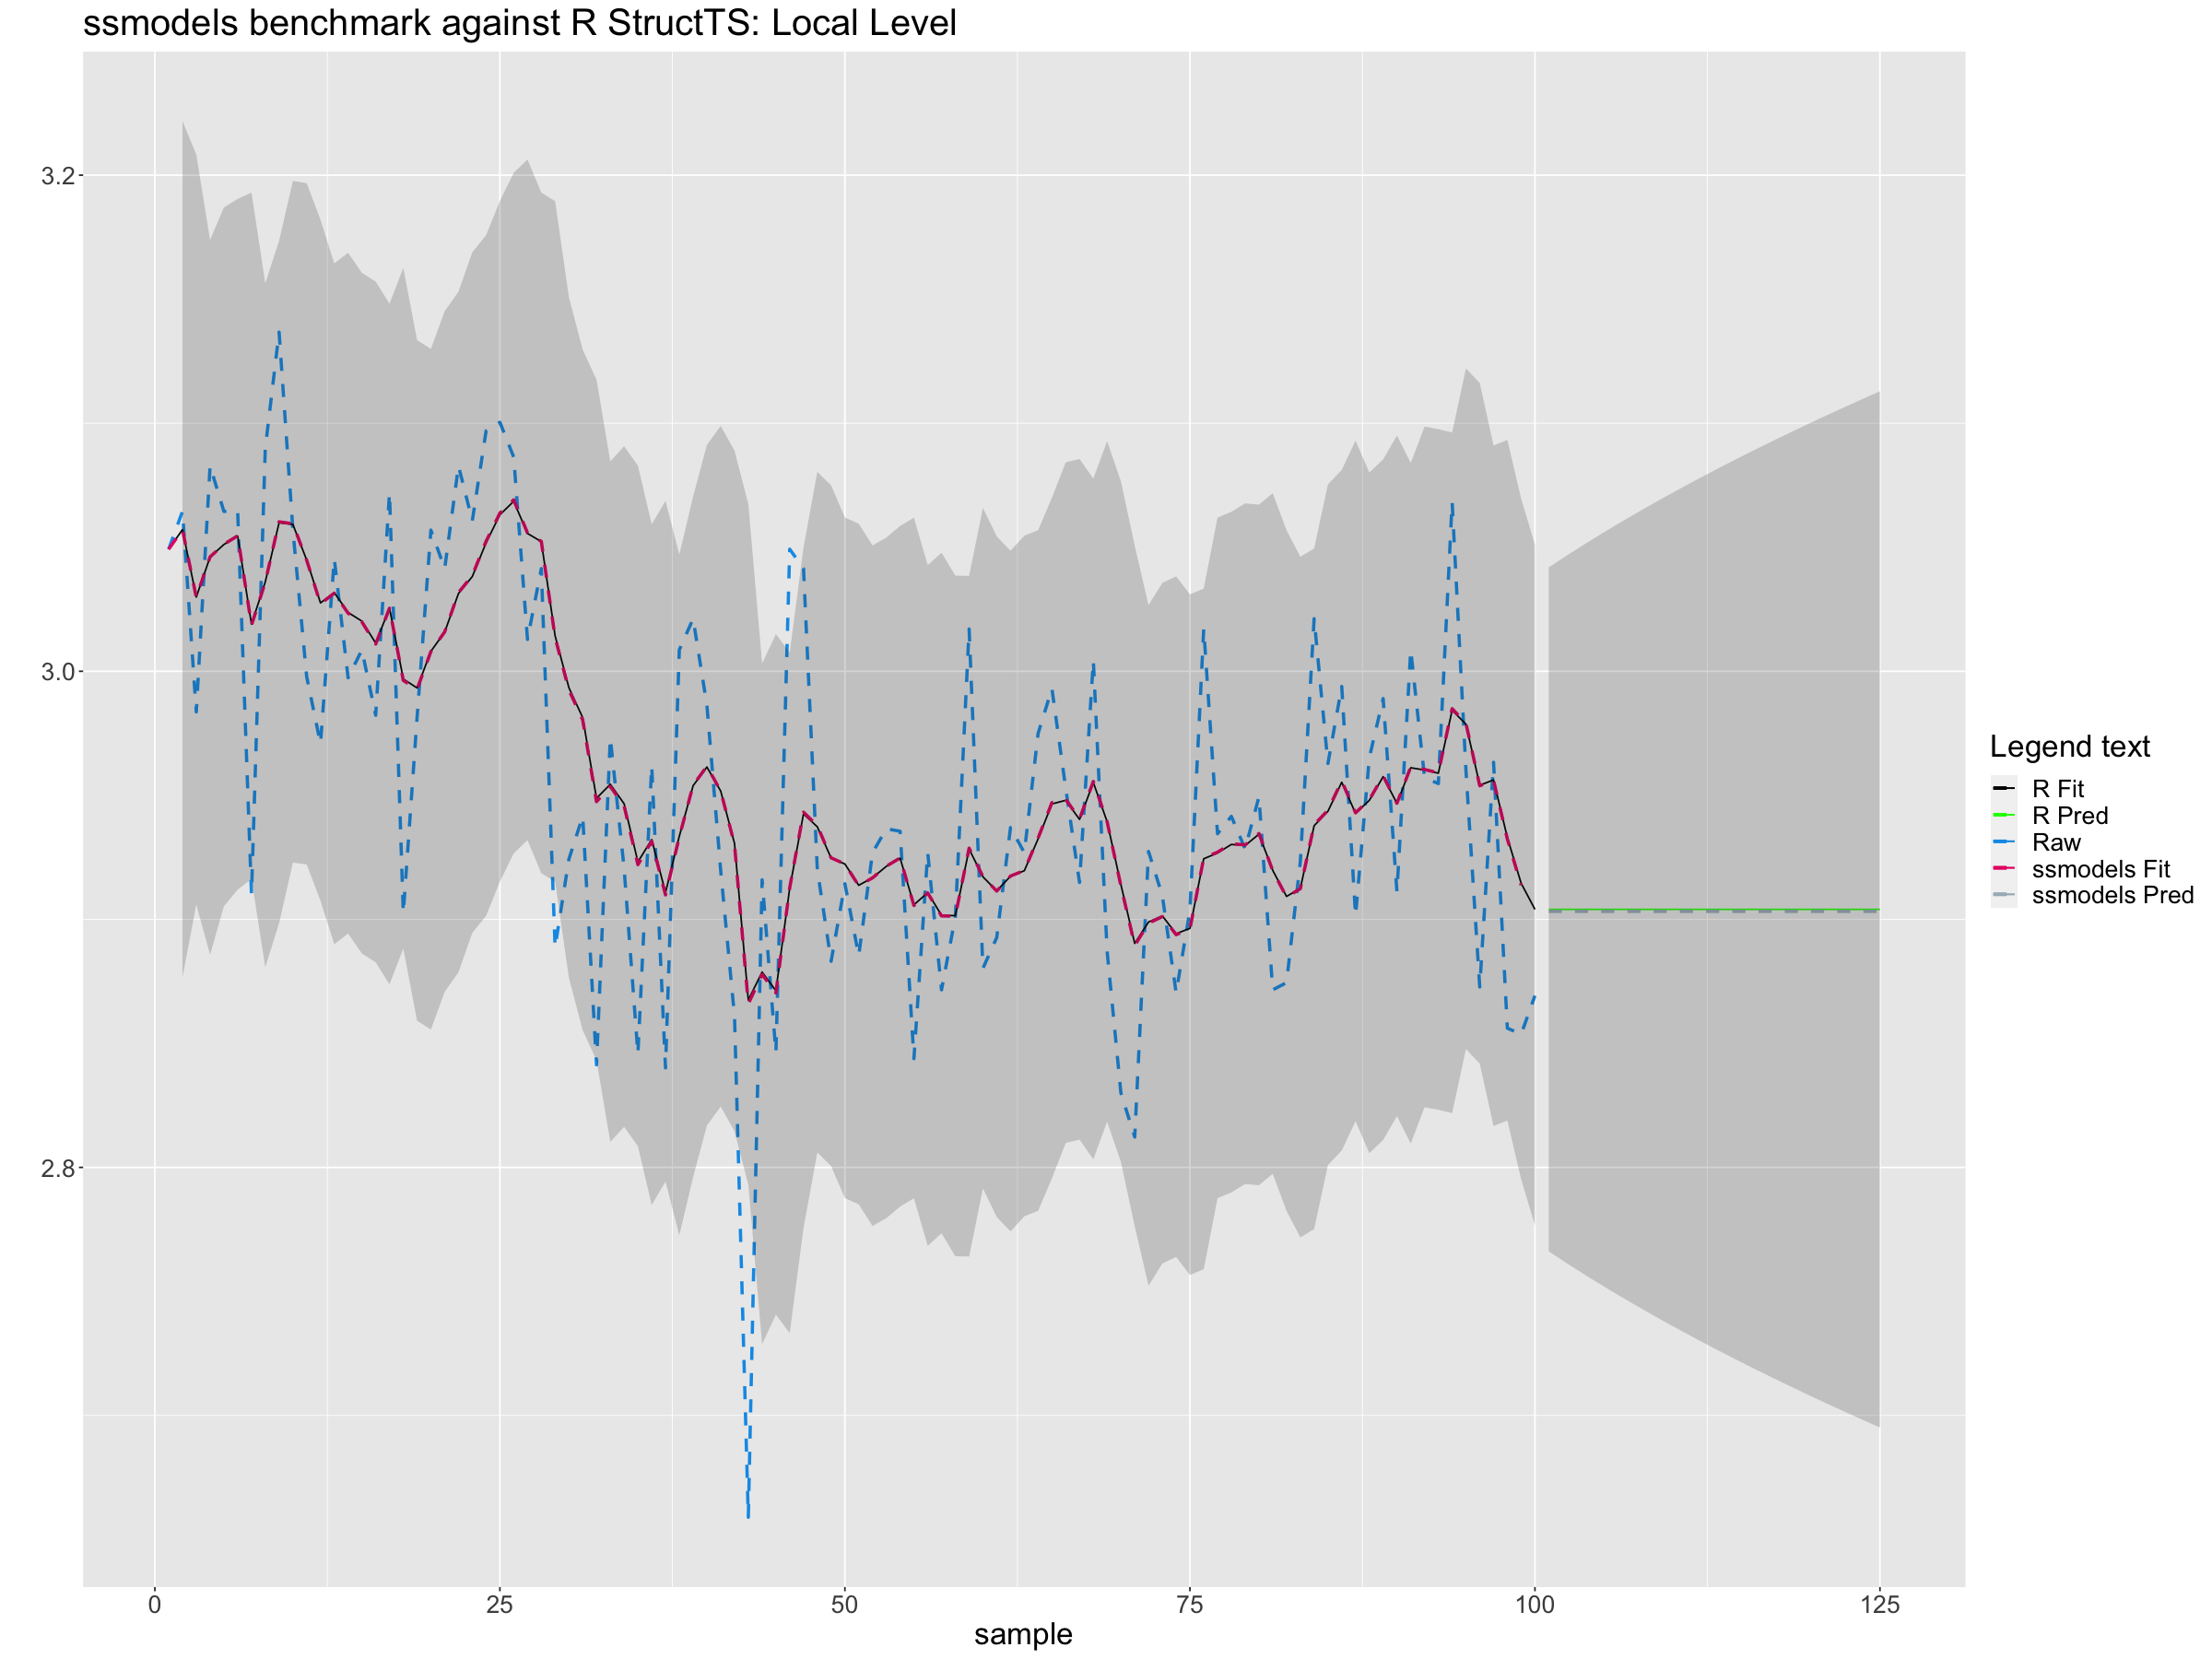

In [208]:
p0

### Numerical comparison between ssmodels and R

In [209]:
fit = data.frame(coef=y.est$coef, coef_ssmodel=coefsMLE) 
fit

,coef,coef_ssmodel
,<dbl>,<dbl>
level,0.0002671003,0.0002749144
epsilon,0.0037980343,0.0037385328
